In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from torchvision import models
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
import torch.nn.functional as F

In [2]:
from src import display
from src import data_transformer as dt
from src import evaluation

In [3]:
from sklearn.metrics import average_precision_score
import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning)

In [4]:
img_path = "data/VOCdevkit/VOC2012/JPEGImages/"
seed = 42
target_size = 224
device = "cuda"

In [5]:
train_json_path = "data/pascal_train2012.json"

In [6]:
id_cat, train_list = dt.load_pascal(train_json_path)

In [7]:
train_list = dt.rescale_bounding_boxes(train_list, target_size)
train_list = dt.convert_to_center(train_list)

In [8]:
example = train_list[0]
example

ImageEntry(filename='2008_000008.jpg', width=500, height=442, classnames=['horse', 'person'], class_id=[12, 14], bounding_boxes=[[117.0, 128.5, 188, 169], [99.5, 53.5, 59, 63]])

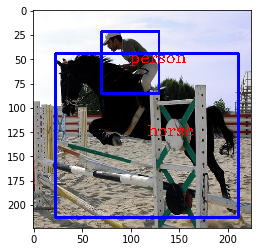

In [9]:
img_str = img_path + example.filename
img = display.read_img(img_str, target_size)

img = display.draw_boxes(img, example.bounding_boxes)
img = display.draw_text(img, example.classnames, example.bounding_boxes)
plt.imshow(img)
plt.show()

In [10]:
anchor_grid = [4, 2, 1] # Number of grid-elements per dimension
anchor_zooms = [0.7, 1.0, 1.3] # How much bigger/smaller each default box will be (percentage)
anchor_ratios = [(1.0, 1.0), (1.0, 0.5), (0.5, 1.0)] # Ratio between (width, height)

anchor_scales = [(anc*h, anc*w) for anc in anchor_zooms for (h,w) in anchor_ratios]
anchor_offsets = [1/(2*o) for o in anchor_grid]
num_boxes = len(anchor_scales)

In [11]:
anchor_x = [np.repeat(np.linspace(ao, 1-ao, ag), ag) for (ao, ag) in zip(anchor_offsets, anchor_grid)]
anchor_x = np.concatenate(anchor_x)

anchor_y = [np.tile(np.linspace(ao, 1-ao, ag), ag) for ao,ag in zip(anchor_offsets, anchor_grid)]
anchor_y = np.concatenate(anchor_y)

anchor_centers = np.repeat(np.stack([anchor_x, anchor_y], axis=1), num_boxes, axis=0)

In [12]:
anchor_sizes  = [np.array([[w/ag, h/ag] for _ in range(ag**2) for w, h in anchor_scales])
                 for ag in anchor_grid]
anchor_sizes = np.concatenate(anchor_sizes)

anchors = np.concatenate([anchor_centers, anchor_sizes], axis=1)
anchors = torch.from_numpy(anchors).float()
anchors = anchors.to(device)

In [13]:
ground_truths = []
classes = []

for item in train_list:
    gt = np.vstack(item.bounding_boxes)
    gt = torch.from_numpy(gt).float() / target_size
    ground_truths.append(gt[None, :, :].to(device))
    
    # Adding +1 since first element should be background
    c = torch.from_numpy(np.array(item.class_id)) + 1
    classes.append(c[None, :].to(device))

In [14]:
def flatten_conv(x, num_boxes):
    samples, channels, _, _ = x.size()
    x = x.permute(0, 2, 3, 1).contiguous()
    return x.view(samples, -1, int(channels/num_boxes))

class StandardConv(nn.Module):
    def __init__(self, in_channels, out_channels, stride=2, drop_rate=0.0):
        super().__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1)
        self.bn = nn.BatchNorm2d(out_channels)

    def forward(self, x):
        x = self.conv(x)
        x = F.relu(x)
        x = self.bn(x)
        return x        

class OutputConv(nn.Module):
    def __init__(self, in_channels, num_boxes):
        super().__init__()
        self.num_boxes = num_boxes
        self.conv_1 = nn.Conv2d(in_channels, (len(id_cat)+1)*num_boxes, kernel_size=3, padding=1)
        self.conv_2 = nn.Conv2d(in_channels, 4*num_boxes, kernel_size=3, padding=1)

    def forward(self, x):
        # [class predictions, box coordinates]
        return [flatten_conv(self.conv_1(x), self.num_boxes), 
                flatten_conv(self.conv_2(x), self.num_boxes)]

class Model(nn.Module):
    def __init__(self, num_boxes):
        super().__init__()
        
        pretrained_model = list(models.vgg16(pretrained='imagenet').children())[:-1]
        self.pretrained_model = nn.Sequential(*pretrained_model)
        
        self.std_conv_1 = StandardConv(512, 256, stride=1)
        self.std_conv_2 = StandardConv(256, 256)
        self.std_conv_3 = StandardConv(256, 256)
        self.std_conv_4 = StandardConv(256, 256)
        
        self.out_conv_1 = OutputConv(256, num_boxes)
        self.out_conv_2 = OutputConv(256, num_boxes)
        self.out_conv_3 = OutputConv(256, num_boxes)
                                       
    def forward(self, x):
        x = self.pretrained_model(x)
        x = F.relu(x)
        x = self.std_conv_1(x)
        x = self.std_conv_2(x)
        output_class_1, output_bb_1 = self.out_conv_1(x)
        
        x = self.std_conv_3(x)
        output_class_2, output_bb_2 = self.out_conv_2(x)
        
        x = self.std_conv_4(x)
        output_class_3, output_bb_3 = self.out_conv_3(x)
        
        # Class, bounding box
        return [torch.cat([output_class_1, output_class_2, output_class_3], dim=1),
                torch.cat([output_bb_1, output_bb_2, output_bb_3], dim=1)
                ]
    
    def change_freezing(self, mode=False):
        for param in self.pretrained_model.parameters():
            param.requires_grad = mode

In [15]:
class PascalData(Dataset):
    def __init__(self, data_list, ground_truths, classes, target_size=target_size, path=img_path):
        self.target_size = target_size
        self.path = path
        
        self.file_list = [i.filename for i in data_list]
        self.ground_truths = ground_truths
        self.classes = classes
            
        self.mean = np.array([0.485, 0.456, 0.406]).reshape((3, 1, 1))
        self.std = np.array([0.229, 0.224, 0.225]).reshape((3, 1, 1))
    
    def __len__(self):
        return len(self.file_list)
    
    def __getitem__(self, idx):
        img_str = self.path + self.file_list[idx]
        
        img = display.read_img(img_str, self.target_size)
        img = img / 255.0
        img = img.transpose((2, 0, 1))
        img = (img - self.mean) / self.std
        img = torch.from_numpy(img).float().to(device)
        
        return (img, self.ground_truths[idx], self.classes[idx])
    
def collate_fn(batch):
    """
    Writing custom collector function since the Dataset class returns both tensors and lists.
    """
    
    x = [b[0] for b in batch]
    x = torch.stack(x, dim=0)
    gt = [b[1] for b in batch]
    c = [b[2] for b in batch]
    return (x, gt, c)

In [16]:
def center_2_hw(box):
    """
    Converting (bx, by, w, h) to (x1, y1, x2, y2)
    """
    
    return torch.cat(
        [box[:, 0, None] - box[:, 2, None]/2,
         box[:, 1, None] - box[:, 3, None]/2,
         box[:, 0, None] + box[:, 2, None]/2,
         box[:, 1, None] + box[:, 3, None]/2
         ], dim=1)

def intersect(anchors, ground_truth):
    max_xy = torch.min(anchors[:, None, 2:], ground_truth[None, :, 2:])
    min_xy = torch.max(anchors[:, None, :2], ground_truth[None, :, :2])
    inter = torch.clamp((max_xy - min_xy), min=0)
    return inter[:, :, 0] * inter[:, :, 1]

def box_area(box): 
    area = (box[:, 2] - box[:, 0]) * (box[:, 3] - box[:, 1])
    return area

def jaccard(anchors, ground_truth):
    """
    Box with shape bx, by, w, h
    """
    
    temp_anchors, temp_ground_truth = center_2_hw(anchors), center_2_hw(ground_truth)
    intersection = intersect(temp_anchors, temp_ground_truth)
    union = box_area(temp_anchors).unsqueeze(1) + box_area(temp_ground_truth).unsqueeze(0) - intersection
    return intersection / union

def find_overlap(bb_true_i, jaccard_overlap=0.4):
    """
    bb_true_i is one bounding box for one image.
    """
    
    jaccard_tensor = jaccard(anchors, bb_true_i)
    _, max_overlap = jaccard_tensor.max(0)
    
    threshold_overlap = (jaccard_tensor > jaccard_overlap).nonzero()
    
    if len(threshold_overlap) > 0:
        threshold_overlap = threshold_overlap[:, 0]
        overlap = torch.cat([max_overlap, threshold_overlap])
        overlap = np.unique(overlap.cpu().detach().numpy())
        overlap = torch.from_numpy(overlap).to(device)        
    else:
        overlap = max_overlap
    
    return overlap

In [17]:
class FocalLoss(nn.Module):
    def __init__(self, alpha=0.25, gamma=2, size_average=True, device="cuda", eps=1e-10):
        super().__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.size_average = size_average
        self.device = device
        self.eps = eps

    def forward(self, input, target):
        p = torch.sigmoid(input)
        pt = p * target.float() + (1.0 - p) * (1 - target).float()
        alpha_t = (1.0 - self.alpha) * target.float() + self.alpha * (1 - target).float()
        loss = - 1.0 * torch.pow((1 - pt), self.gamma) * torch.log(pt + self.eps)

        if self.size_average:
            loss = loss.mean()
        else:
            loss = loss.sum()
        return loss
    
fl = FocalLoss(size_average=False)

In [18]:
def one_hot_encoding(labels, num_classes):
    return torch.eye(num_classes)[labels]

def ssd_loss(class_hat, bb_hat, class_true, bb_true):
    loss = 0.0
    for i in range(len(class_true)):  # Batch level
        class_hat_i = class_hat[i, :, :]
        bb_true_i = bb_true[i]
        class_true_i = class_true[i]

        target = torch.zeros(class_hat_i.shape[0]).long().to(device)

        loc_loss = 0.0
        for j in range(bb_true_i.shape[1]):  # BB level
            overlap = find_overlap(bb_true_i[None, 0, j, :])
            target[overlap] = class_true_i[0, j]
            
            loc_loss += F.smooth_l1_loss(bb_true_i[0, j, :], bb_hat[None, i, overlap, :], reduction="mean")

        target = one_hot_encoding(target, len(id_cat) + 1).float().to(device)
        class_loss = fl(class_hat_i, target)
        class_loss = class_loss/len(id_cat)

        loss += (class_loss + loc_loss) / class_true[i].shape[1]

    loss = loss / len(class_true)
    return loss

In [19]:
torch.manual_seed(seed)
model = Model(num_boxes=num_boxes).to(device)
model.change_freezing(False)

In [20]:
batch_size = 64
train_dataset = PascalData(train_list, ground_truths, classes)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0, collate_fn=collate_fn)

In [21]:
n_epochs = 40
lr = 1e-4
wd = 0.0005

In [22]:
optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=lr, weight_decay=wd)

In [23]:
# 23.4834
torch.manual_seed(seed)
for epoch in range(1, n_epochs+1):
    model.train()
    train_loss = 0.0

    for _, (x, bb_true, class_true) in enumerate(train_loader):
        model.zero_grad()
        class_hat, bb_hat = model(x)

        batch_loss = ssd_loss(class_hat, bb_hat, class_true, bb_true)
        batch_loss.backward()
        optimizer.step()

        train_loss += batch_loss

    train_loss = (train_loss/len(train_loader)).detach().cpu().numpy()
    print(f"----- epoch {epoch} -----")
    print("Train loss: {:.4f}".format(train_loss))

----- epoch 1 -----
Train loss: 10.3990
----- epoch 2 -----
Train loss: 1.8139
----- epoch 3 -----
Train loss: 1.2279
----- epoch 4 -----
Train loss: 0.9617
----- epoch 5 -----
Train loss: 0.7569
----- epoch 6 -----
Train loss: 0.6067
----- epoch 7 -----
Train loss: 0.5046
----- epoch 8 -----
Train loss: 0.4360
----- epoch 9 -----
Train loss: 0.3898
----- epoch 10 -----
Train loss: 0.3528
----- epoch 11 -----
Train loss: 0.3244
----- epoch 12 -----
Train loss: 0.2998
----- epoch 13 -----
Train loss: 0.2776
----- epoch 14 -----
Train loss: 0.2590
----- epoch 15 -----
Train loss: 0.2427
----- epoch 16 -----
Train loss: 0.2285
----- epoch 17 -----
Train loss: 0.2164
----- epoch 18 -----
Train loss: 0.2062
----- epoch 19 -----
Train loss: 0.1964
----- epoch 20 -----
Train loss: 0.1868
----- epoch 21 -----
Train loss: 0.1798
----- epoch 22 -----
Train loss: 0.1700
----- epoch 23 -----
Train loss: 0.1615
----- epoch 24 -----
Train loss: 0.1553
----- epoch 25 -----
Train loss: 0.1502
----- ep

In [69]:
i = 5
(x, bb_true, class_true) = train_dataset[i]
img_file = train_dataset.file_list[i]

background_threshold = 0.5

In [70]:
x = x[None, :, :, :]
model.eval()
class_hat, bb_hat = model(x)
bb_hat = bb_hat * target_size

In [71]:
class_hat = class_hat.sigmoid()

In [72]:
class_hat = class_hat[0, :, :]
bb_hat = bb_hat[0, :, :]

In [73]:
# Filtering with < since we want low probability of background
bb_hat = bb_hat[class_hat[:,0] < background_threshold, :]
class_hat = class_hat[class_hat[:,0] < background_threshold, :]

In [74]:
class_preds = class_hat[:, 1:]

In [75]:
prob, class_id = class_preds.max(1)

In [76]:
prob = prob.detach().cpu().numpy()
class_id = class_id.detach().cpu().numpy()
bb_hat = bb_hat.detach().cpu().numpy()

In [77]:
output_bb = [[prob[i], class_id[i], id_cat[class_id[i]],
             bb_hat[i, 0], bb_hat[i, 1], bb_hat[i, 2], bb_hat[i, 3]] 
             for i in range(len(prob))]

output_bb = sorted(output_bb, key = lambda x: x[0], reverse=True)

In [78]:
filtered_bb = evaluation.non_max_suppression(output_bb)

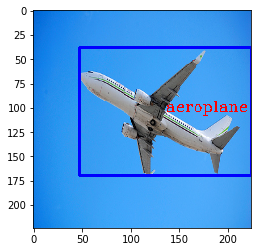

In [79]:
img_str = img_path + img_file
img = display.read_img(img_str, target_size)

img = display.read_img(img_str, target_size)
img = display.draw_boxes(img, [bb[3:] for bb in filtered_bb])
img = display.draw_text(img, [bb[2] for bb in filtered_bb], [bb[3:] for bb in filtered_bb])
plt.imshow(img)
plt.show()

In [35]:
num_samples = 50
mAP = 0.0
jaccard_threshold = 0.5

model.eval()
for i in range(num_samples):
    (x, bb_true, class_true) = train_dataset[i]
    img_file = train_dataset.file_list[i]
    class_true = class_true.squeeze(0) - 1 # -1 to convert it from 1-21 to 0-20

    x = x[None, :, :, :]
    class_hat, bb_hat = model(x)

    jacard_values = jaccard(bb_hat.squeeze(0), bb_true.squeeze(0))
    jacard_values = (jacard_values > jaccard_threshold).nonzero()
    
    if len(jacard_values) == 0:
        # No BB found
        continue
    
    class_hat = class_hat[0, :, 1:].sigmoid()

    ap = 0.0
    for index in range(len(class_true)):
        overlap = jacard_values[jacard_values[:, 1] == index]

        if len(overlap) > 0:
            class_hat = class_hat[overlap[:,0], :]
            prob, class_id = class_hat.max(1)

            prob, sort_index = prob.sort(descending=True)
            class_id = class_id[sort_index]

            prob[class_id != class_true[index]] = 0.0
            prob = prob.detach().cpu().numpy()

            y_true = class_id == class_true[index]
            y_true = y_true.detach().cpu().numpy()

            temp_ap = average_precision_score(y_true, prob)

            if not np.isnan(temp_ap):
                ap += temp_ap

    ap = ap / len(class_true)
    mAP += ap
    
mAP = mAP / num_samples
mAP = round(mAP, 4)
mAP

0.6108